In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
#import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
import librosa

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [5]:
DATASET_ID = 'gibbon_morita_segmented'

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [132]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=50,
    mel_upper_edge_hertz=7999,
    butter_lowcut = 50,
    butter_highcut = 7999,
    ref_level_db = 20,
    min_level_db = -50,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

In [133]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  81 out of 128 | elapsed:    8.2s remaining:    4.7s


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   12.4s finished


In [10]:
dataset.sample_json

OrderedDict([('datetime', '2017-09-12_07-00-02'),
             ('species', 'Hylobatidae'),
             ('common_name', 'Gibbon'),
             ('samplerate_hz', 16000),
             ('original_wav',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/gibbon_morita/gibbon_superregular_data/test_data/20170912-070002_01_ch.wav'),
             ('length_s', 1800.0),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/gibbon_morita/gibbon_superregular_data/test_data/20170912-070002_01_ch.wav'),
             ('indvs',
              OrderedDict([('UNK',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [349.04,
                                                         390.04,
                                                         422.44,
                                                     

In [11]:
len(dataset.data_files)

128

#### Create dataset based upon JSON

In [12]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1911s.) Setting batch_size=2.


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  81 out of 128 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  94 out of 128 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 107 out of 128 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.2s finished


10333

In [14]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key
0,349.04,350.98,UNK,0,20170912-070002_01_ch
1,390.04,391.94,UNK,0,20170912-070002_01_ch
2,422.44,425.08,UNK,0,20170912-070002_01_ch


### get audio for dataset

In [32]:
def get_row_audio(syllable_df, wav_loc, hparams):
    """ load audio and grab individual syllables
    TODO: for large sparse WAV files, the audio should be loaded only for the syllable
    """

    # load audio
    data, rate  = librosa.core.load(wav_loc, sr = None)
    #data = np.nan_to_num(data)
    # get audio for each syllable
    syllable_df["audio"] = [
        data[int(st * rate) : int(et * rate)]
        for st, et in zip(syllable_df.start_time.values, syllable_df.end_time.values)
    ]
    
    syllable_df["rate"] = rate

    return syllable_df

In [66]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    7.3s


[Parallel(n_jobs=-1)]: Done  94 out of 128 | elapsed:    9.1s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 107 out of 128 | elapsed:   10.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 120 out of 128 | elapsed:   11.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   12.7s finished


10333

In [67]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [68]:
syllable_df = syllable_df[np.array(df_mask)]

In [69]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate
0,349.04,350.98,UNK,0,20170912-070002_01_ch,"[0.00036621094, 0.00024414062, 0.0004272461, 0...",16000
1,390.04,391.94,UNK,0,20170912-070002_01_ch,"[-0.00015258789, 9.1552734e-05, 0.0005187988, ...",16000
2,422.44,425.08,UNK,0,20170912-070002_01_ch,"[0.0004272461, 9.1552734e-05, 0.0, -0.00036621...",16000


In [70]:
aud_max = [np.max(np.abs(i)) for i in syllable_df.audio.values]

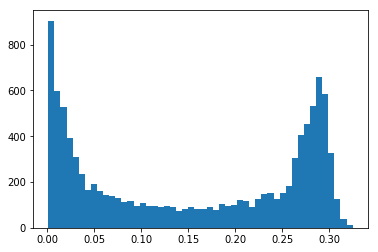

In [71]:
plt.hist(aud_max, bins= 50);

In [74]:
np.sum(np.array(aud_max)  > 0.01)

9220

In [75]:
df_mask  = np.array(aud_max)  > 0.01

In [76]:
syllable_df = syllable_df[np.array(df_mask)]

In [77]:
sylls = syllable_df.audio.values

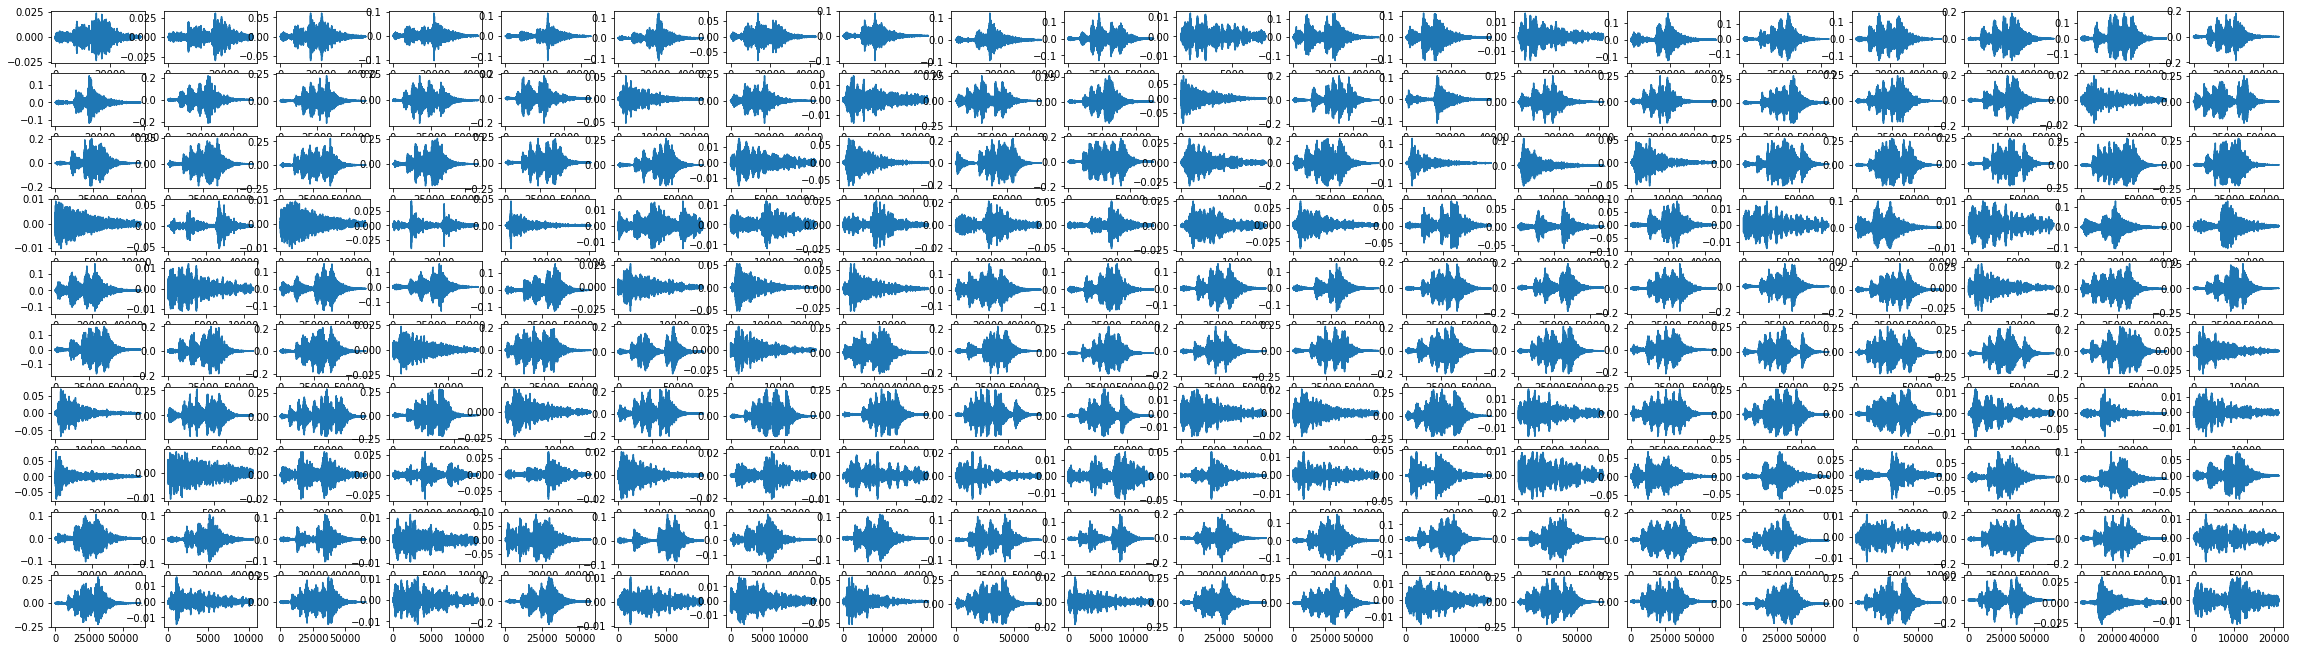

In [78]:
nrows = 10
ncols = 20
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [85]:
syllable_df['audio'] = [i/np.max(np.abs(i)) for i in syllable_df.audio.values]

### Create spectrograms

In [134]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [135]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [136]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1972s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 303 ta

[Parallel(n_jobs=-1)]: Done 9173 out of 9220 | elapsed:  1.0min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 9220 out of 9220 | elapsed:  1.0min finished


### Rescale spectrogram
- using log rescaling

In [137]:
log_scaling_factor = 4

In [138]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0097s.) Setting batch_size=40.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1584s.) Setting batch_size=100.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2068 tasks      | elapsed:    1.4s
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/process_executo

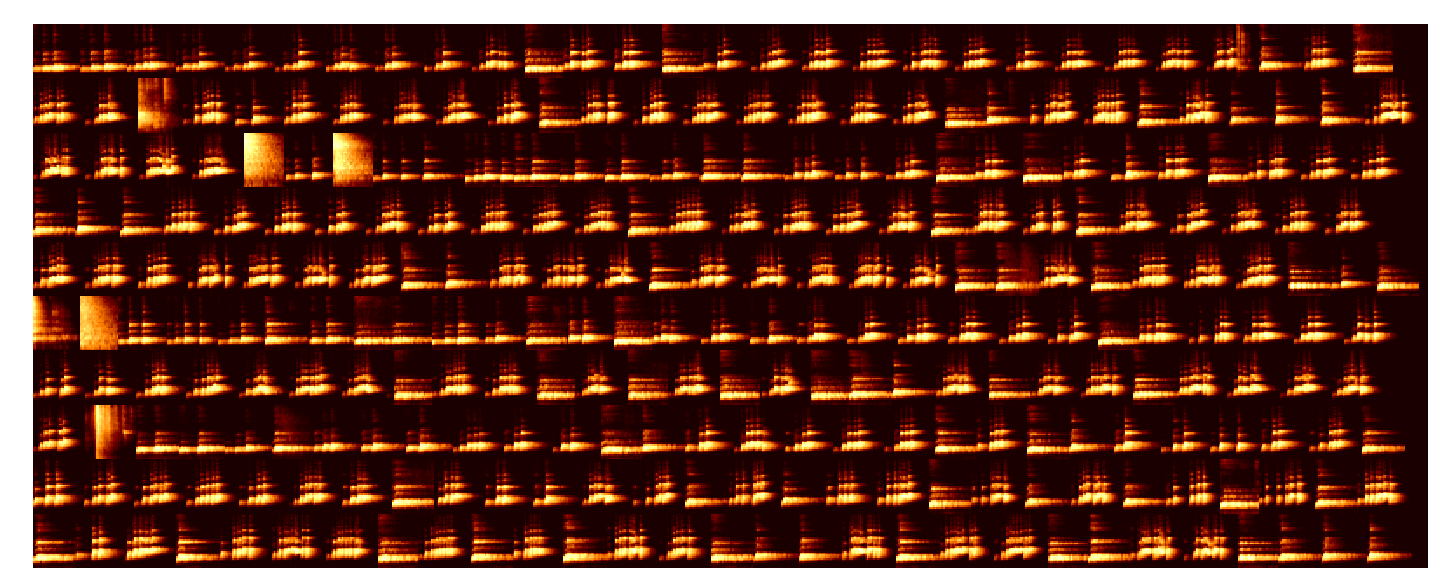

In [139]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [140]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [141]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,349.04,350.98,UNK,0,20170912-070002_01_ch,"[0.015189873, 0.010126582, 0.017721519, 0.0303...",16000,"[[0, 0, 0, 73, 58, 59, 66, 60, 62, 55, 58, 61,..."
1,390.04,391.94,UNK,0,20170912-070002_01_ch,"[-0.0049751243, 0.0029850747, 0.016915424, 0.0...",16000,"[[0, 0, 0, 49, 56, 48, 48, 52, 50, 45, 50, 40,..."
2,422.44,425.08,UNK,0,20170912-070002_01_ch,"[0.0069101676, 0.0014807503, 0.0, -0.005923001...",16000,"[[3, 3, 3, 16, 25, 33, 35, 32, 26, 16, 11, 13,..."


In [142]:
import seaborn as sns

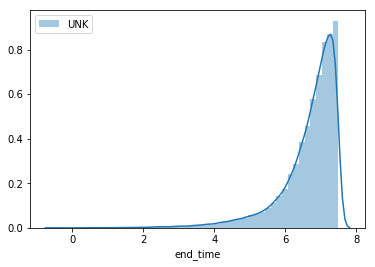

In [143]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [144]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1767s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0292s.) Setting batch_size=26.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0962s.) Setting batch_size=108.
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1121 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 9220 out of 9220 | elapsed:    4.1s finished


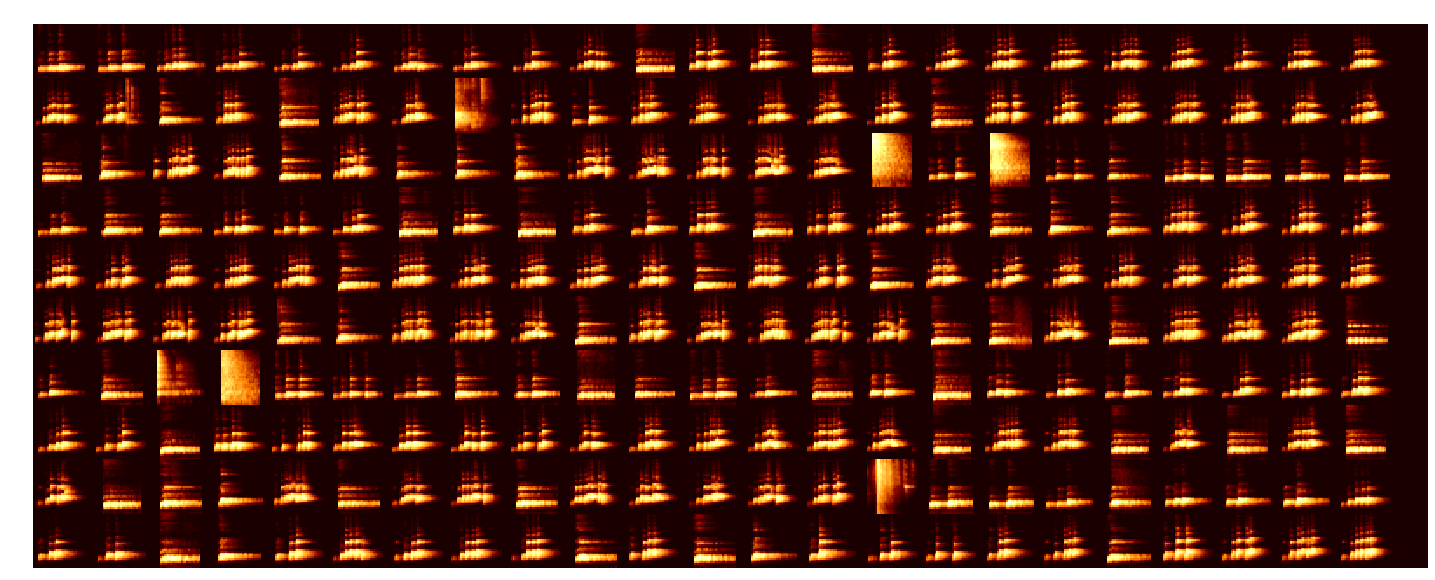

In [145]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

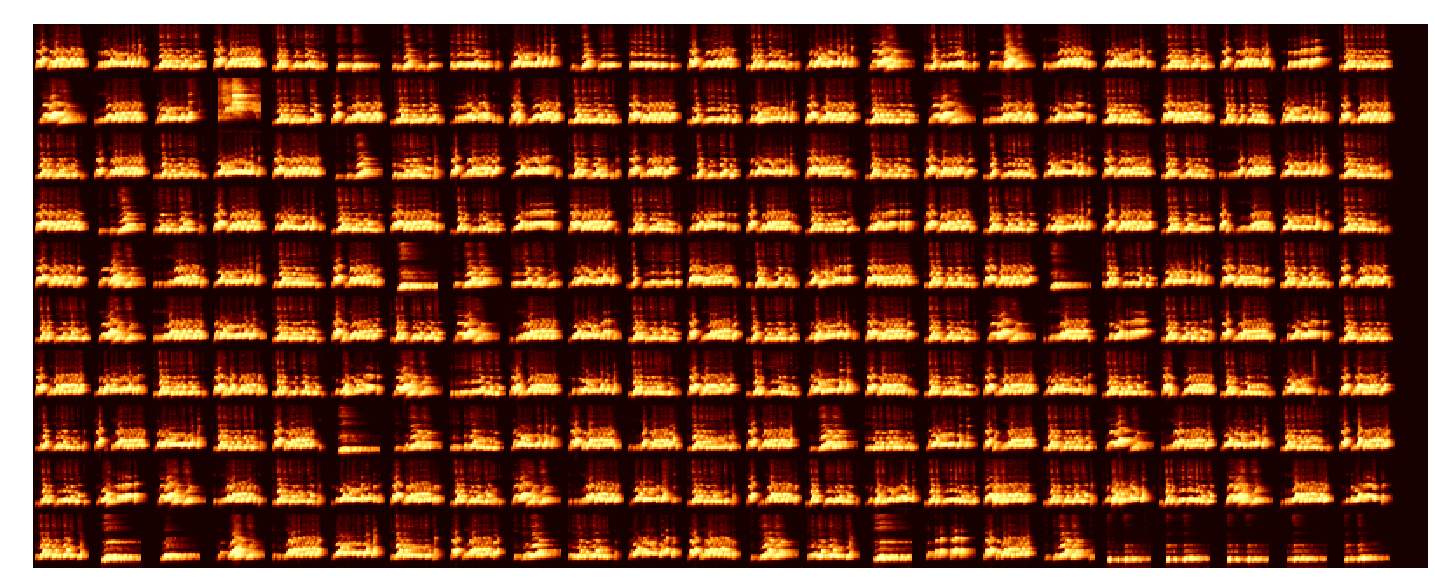

In [146]:
draw_spec_set(syllables_spec[-1000:], zoom=1, maxrows=10, colsize=25)

In [147]:
np.shape(syllables_spec)

(9220, 32, 34)

In [148]:
syllable_df['spectrogram'] = syllables_spec

In [149]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [150]:
# convert to uint8 to save space
syllable_df['spectrogram'] = [(norm(i)*255).astype('uint8') for i in syllables_spec]

In [151]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,349.04,350.98,UNK,0,20170912-070002_01_ch,"[0.015189873, 0.010126582, 0.017721519, 0.0303...",16000,"[[5, 5, 5, 17, 11, 10, 14, 14, 8, 10, 10, 13, ..."
1,390.04,391.94,UNK,0,20170912-070002_01_ch,"[-0.0049751243, 0.0029850747, 0.016915424, 0.0...",16000,"[[3, 3, 3, 4, 8, 4, 4, 6, 5, 5, 6, 3, 4, 7, 5,..."
2,422.44,425.08,UNK,0,20170912-070002_01_ch,"[0.0069101676, 0.0014807503, 0.0, -0.005923001...",16000,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."


### view syllables per indv

In [152]:
syllable_df.indv.unique()

array(['UNK'], dtype=object)

UNK 9220


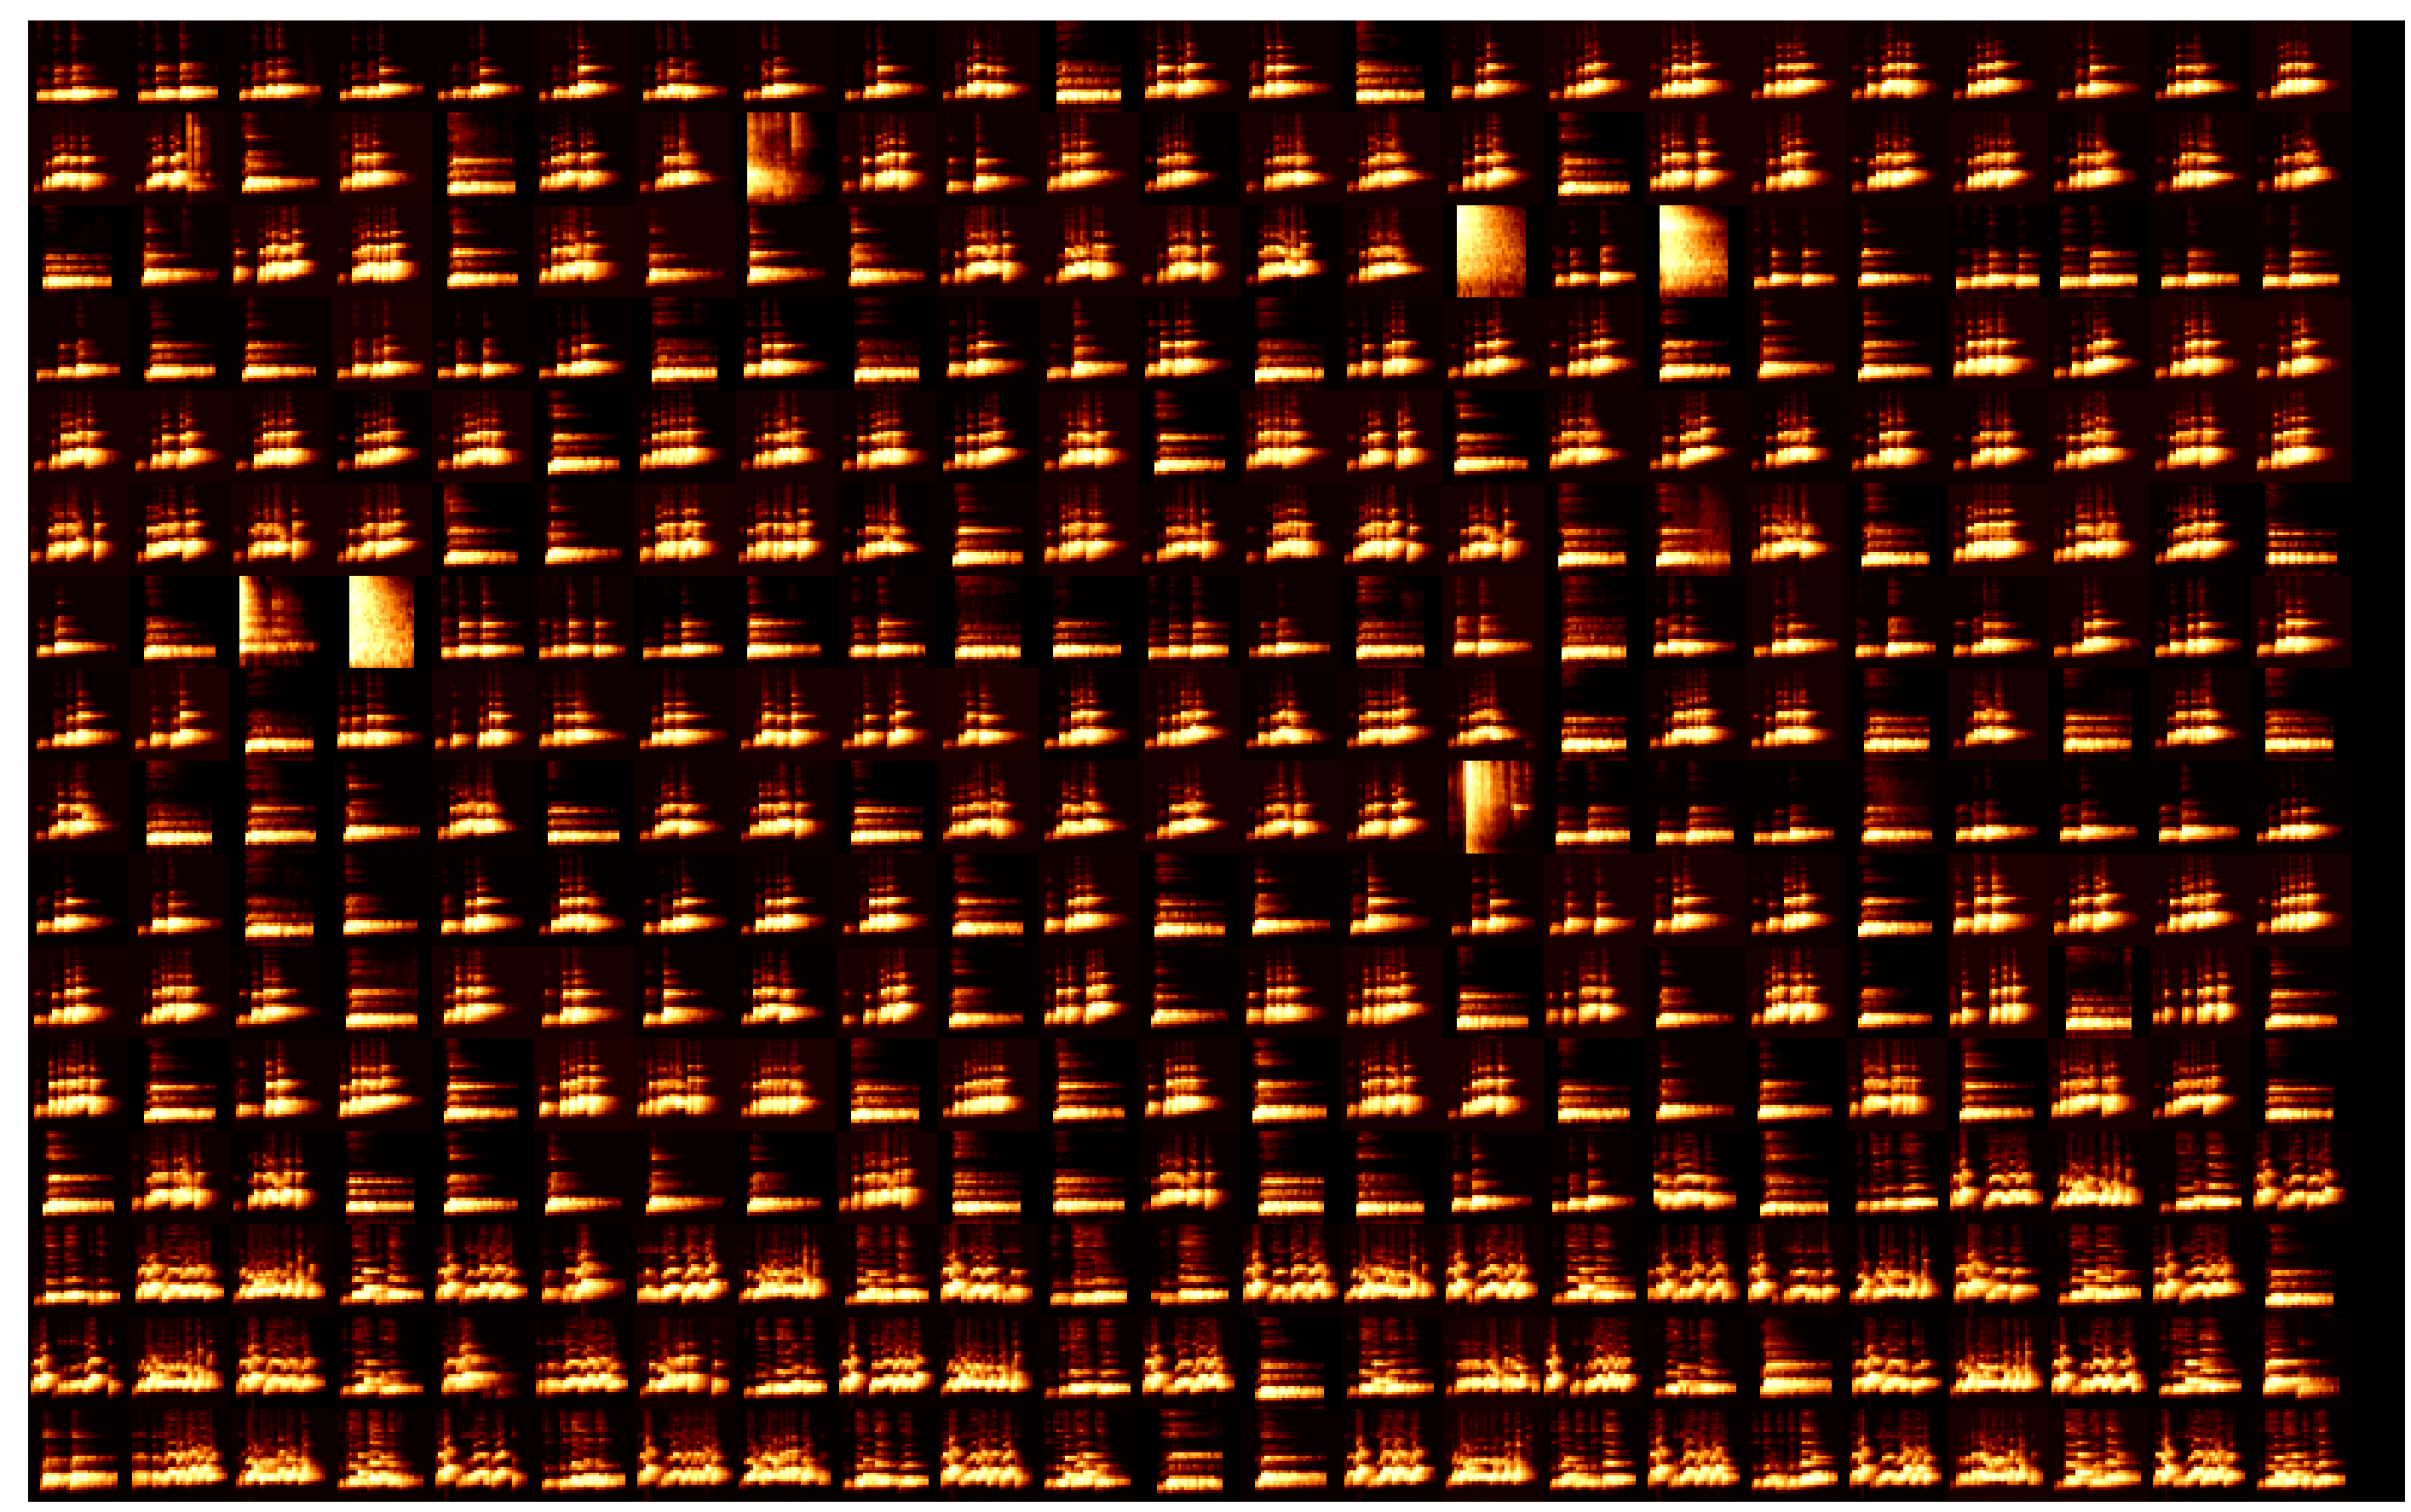

In [153]:
for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [154]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'gibbon_lower.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)